# Test convergence of `P1` element for Poisson equation

## Define forms and errors

In [1]:
from skfem import *
import numpy as np
from utils import solver_iter_krylov, solver_iter_pyamg, solver_iter_mgcg
from skfem.helpers import d, dd, ddd, dot, ddot, grad, dddot, prod
from scipy.sparse.linalg import LinearOperator, minres
from skfem.models.poisson import *
from skfem.assembly import BilinearForm, LinearForm
import datetime
import pandas as pd
import sys
import time
import matplotlib.pyplot as plt
from skfem.visuals.matplotlib import draw, plot
from scipy.sparse.linalg import *

pi = np.pi
sin = np.sin
cos = np.cos
exp = np.exp

epsilon = 0

In [2]:
@BilinearForm
def laplace(u, v, w):
    '''
    for $(\nabla w_{h}, \nabla \chi_{h})$
    '''
    return dot(grad(u), grad(v))



@LinearForm
def f_load(v, w):
    '''
    for $(f, x_{h})$
    '''
    pix = pi * w.x[0]
    piy = pi * w.x[1]
    lu = 2 * (pi)**2 * (cos(2*pix)*((sin(piy))**2) + cos(2*piy)*((sin(pix))**2))
    llu = - 8 * (pi)**4 * (cos(2*pix)*sin(piy)**2 + cos(2*piy)*sin(pix)**2 - cos(2*pix)*cos(2*piy))
    return (epsilon**2 * llu - lu) * v


@BilinearForm
def b_load(u, v, w):
    '''
    for $b_{h}$
    '''
    return dot(grad(u), grad(v))


@BilinearForm
def wv_load(u, v, w):
    '''
    for $(\nabla \chi_{h}, \nabla_{h} v_{h})$
    '''
    return dot(grad(u), grad(v))

In [3]:
def exact_u(x, y):
    return (sin(pi * x) * sin(pi * y))**2

def dexact_u(x, y):
    dux = 2 * pi * cos(pi * x) * sin(pi * x) * sin(pi * y)**2
    duy = 2 * pi * cos(pi * y) * sin(pi * x)**2 * sin(pi * y)
    return dux, duy

def ddexact(x, y):
    duxx = 2*pi**2*cos(pi*x)**2*sin(pi*y)**2 - 2*pi**2*sin(pi*x)**2*sin(pi*y)**2
    duxy = 2*pi*cos(pi*x)*sin(pi*x)*2*pi*cos(pi*y)*sin(pi*y)
    duyx = duxy
    duyy = 2*pi**2*cos(pi*y)**2*sin(pi*x)**2 - 2*pi**2*sin(pi*y)**2*sin(pi*x)**2
    return duxx, duxy, duyx, duyy

@Functional
def L2uError(w):
    x, y = w.x
    return (w.w - exact_u(x, y))**2

def get_DuError(basis, u):
    duh = basis.interpolate(u).grad
    x = basis.global_coordinates().value
    dx = basis.dx  # quadrature weights
    dux, duy = dexact_u(x[0], x[1])
    return np.sqrt(np.sum(((duh[0] - dux)**2 + (duh[1] - duy)**2) * dx))

def get_D2uError(basis, u):
    dduh = basis.interpolate(u).hess
    x = basis.global_coordinates().value  # coordinates of quadrature points [x, y]
    dx = basis.dx  # quadrature weights
    duxx, duxy, duyx, duyy = ddexact(x[0], x[1])
    return np.sqrt(
        np.sum(((dduh[0][0] - duxx)**2 + (dduh[0][1] - duxy)**2 +
                (dduh[1][1] - duyy)**2 + (dduh[1][0] - duyx)**2) * dx))

## Test convergence of $uh_0$
$$
\begin{aligned}
\left(\nabla w_{h}, \nabla \chi_{h}\right) &=\left(f, \chi_{h}\right) & & \forall \chi_{h} \in W_{h} \\
b_{h}\left(u_{h 0}, v_{h}\right) &=\left(\nabla w_{h}, \nabla_{h} v_{h}\right) & & \forall v_{h} \in V_{h 0}
\end{aligned}
$$

In [4]:
L2_list = []
Du_list = []
D2u_list = []
h_list = []
epu_list = []
m = MeshTri()

for i in range(1, 7):
    
    #####################
    m.refine()
    element = {'w': ElementTriP1(), 'u': ElementTriMorley()}
    basis = {variable: InteriorBasis(m, e, intorder=4)
        for variable, e in element.items()} 

    K1 = asm(laplace, basis['w'])
    f1 = asm(f_load, basis['w'])

    wh = solve(*condense(K1, f1, D=m.boundary_nodes()), solver=solver_iter_mgcg())

    K2 = asm(b_load, basis['u'])
    f2 = asm(wv_load, basis['w'], basis['u']) * wh
    uh0 = solve(*condense(K2, f2, D=basis['u'].find_dofs()), solver=solver_iter_mgcg())

    U = basis['u'].interpolate(uh0).value
    #####################
    
    L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
    Du = get_DuError(basis['u'], uh0)
    H1u = Du + L2u
    D2u = get_D2uError(basis['u'], uh0)
    H2u = Du + L2u + D2u
    epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
    h_list.append(m.param())
    Du_list.append(Du)
    L2_list.append(L2u)
    D2u_list.append(D2u)
    epu_list.append(epu)

hs = np.array(h_list)
L2s = np.array(L2_list)
Dus = np.array(Du_list)
D2us = np.array(D2u_list)
epus = np.array(epu_list)
H1s = L2s + Dus
H2s = H1s + D2us
print('epsilon =', epsilon)
print('  h    L2u   H1u   H2u   epu')
for i in range(H2s.shape[0] - 1):
    print(
        '2^-' + str(i + 2),
        ' {:.2f}  {:.2f}  {:.2f}  {:.2f}'.format(-np.log2(L2s[i + 1] / L2s[i]),
                                                -np.log2(H1s[i + 1] / H1s[i]),
                                                -np.log2(H2s[i + 1] / H2s[i]),
                                                -np.log2(epus[i + 1] / epus[i])))

epsilon = 0
  h    L2u   H1u   H2u   epu
2^-2  1.43  0.77  0.45  0.70
2^-3  2.29  1.66  0.81  1.61
2^-4  2.31  1.89  0.94  1.87
2^-5  2.14  1.97  0.98  1.96
2^-6  2.04  1.99  1.00  1.99


## Test convergence of $wh$
$$
\begin{aligned}
\left(\nabla w_{h}, \nabla \chi_{h}\right) &=\left(f, \chi_{h}\right) & & \forall \chi_{h} \in W_{h} 
\end{aligned}
$$

In [22]:
L2_list = []
Du_list = []
D2u_list = []
h_list = []
epu_list = []
m = MeshTri()

for i in range(1, 7):
    
    #####################
    m.refine()
    element = ElementTriP2()
    basis = InteriorBasis(m, element)

    K1 = asm(laplace, basis)
    f1 = asm(f_load, basis)

    wh = solve(*condense(K1, f1, D=m.boundary_nodes()), solver=solver_iter_mgcg())
    W = basis.interpolate(wh).value
    #####################
    
    L2u = np.sqrt(L2uError.assemble(basis, w=W))
    Du = get_DuError(basis, wh)
    H1u = Du + L2u
    h_list.append(m.param())
    Du_list.append(Du)
    L2_list.append(L2u)

hs = np.array(h_list)
L2s = np.array(L2_list)
Dus = np.array(Du_list)
H1s = L2s + Dus
print('epsilon =', epsilon)
print('  h    L2u   H1u')
for i in range(H2s.shape[0] - 1):
    print('2^-{}  {:.2f}  {:.2f} '.format(i + 2, -np.log2(L2s[i + 1] / L2s[i]), -np.log2(H1s[i + 1] / H1s[i])))

epsilon = 0
  h    L2u   H1u
2^-2  2.58  1.69 
2^-3  3.09  1.89 
2^-4  3.04  1.97 
2^-5  3.01  1.99 
2^-6  2.99  2.00 


## Other elems

In [37]:
L2_list = []
Du_list = []
D2u_list = []
h_list = []
epu_list = []
m = MeshTri()

for i in range(1, 7):
    
    #####################
    m.refine()
    element = {'w': ElementTriMorley(), 'u': ElementTriMorley()}
    basis = {variable: InteriorBasis(m, e)
        for variable, e in element.items()} 

    K1 = asm(laplace, basis['w'])
    f1 = asm(f_load, basis['w'])

    wh = solve(*condense(K1, f1, D=m.boundary_nodes()), solver=solver_iter_mgcg())

    K2 = asm(b_load, basis['u'])
    f2 = asm(wv_load, basis['w'], basis['u']) * wh
    uh0 = solve(*condense(K2, f2, D=basis['u'].find_dofs()), solver=solver_iter_mgcg())

    U = basis['u'].interpolate(uh0).value
    #####################
    
    L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
    Du = get_DuError(basis['u'], uh0)
    H1u = Du + L2u
#     D2u = get_D2uError(basis['u'], uh0)
#     H2u = Du + L2u + D2u
#     epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
    h_list.append(m.param())
    Du_list.append(Du)
    L2_list.append(L2u)
#     D2u_list.append(D2u)
#     epu_list.append(epu)

hs = np.array(h_list)
L2s = np.array(L2_list)
Dus = np.array(Du_list)
# D2us = np.array(D2u_list)
# epus = np.array(epu_list)
H1s = L2s + Dus
# H2s = H1s + D2us
print('epsilon =', epsilon)
print('  h    L2u   H1u')
for i in range(H2s.shape[0] - 1):
    print(
        '2^-' + str(i + 2),
        ' {:.2f}  {:.2f}'.format(-np.log2(L2s[i + 1] / L2s[i]),
                                                -np.log2(H1s[i + 1] / H1s[i])))

epsilon = 0
  h    L2u   H1u
2^-2  0.14  -0.11
2^-3  -0.18  -0.30
2^-4  -0.06  -0.09
2^-5  -0.02  -0.02
2^-6  -0.00  -0.01


# Different mesh

In [19]:
from skfem.io import from_meshio
from skfem.io.json import from_file, to_file
from pathlib import Path

## loading mesh

In [24]:
m = from_file('mesh.json')

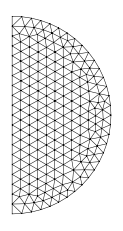

In [25]:
draw(m)

In [30]:
import meshio

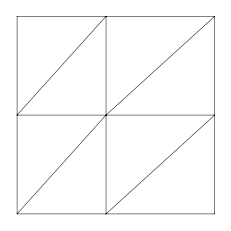

In [36]:
m = MeshTri.init_tensor([0.0, 0.45, 1.0], [0.0, 0.5, 1.0])
draw(m)

epsilon = 0
  h    L2u   H1u
2^-2  3.27  2.10
2^-3  3.32  1.94
2^-4  3.30  1.97
2^-5  3.15  1.99
2^-6  3.04  2.00


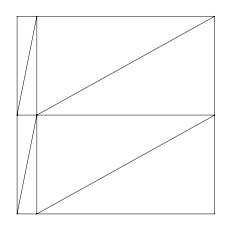

In [64]:
L2_list = []
Du_list = []
D2u_list = []
h_list = []
epu_list = []
m = MeshTri.init_tensor([0.0, 0.1, 1.0], [0.0, 0.5, 1.0])
draw(m)

for i in range(1, 7):
    
    #####################
    m.refine()
    element = {'w': ElementTriP2(), 'u': ElementTriMorley()}
    
    basis = {variable: InteriorBasis(m, e, intorder=4)
        for variable, e in element.items()} 

    K1 = asm(laplace, basis['w'])
    f1 = asm(f_load, basis['w'])

    wh = solve(*condense(K1, f1, D=m.boundary_nodes()), solver=solver_iter_mgcg())

    K2 = asm(b_load, basis['u'])
    f2 = asm(wv_load, basis['w'], basis['u']) * wh
    uh0 = solve(*condense(K2, f2, D=basis['u'].find_dofs()), solver=solver_iter_mgcg())

    U = basis['u'].interpolate(uh0).value
    #####################
    
    L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
    Du = get_DuError(basis['u'], uh0)
    H1u = Du + L2u
    h_list.append(m.param())
    Du_list.append(Du)
    L2_list.append(L2u)

hs = np.array(h_list)
L2s = np.array(L2_list)
Dus = np.array(Du_list)
H1s = L2s + Dus
print('epsilon =', epsilon)
print('  h    L2u   H1u')
for i in range(H1s.shape[0] - 1):
    print(
        '2^-' + str(i + 2),
        ' {:.2f}  {:.2f}'.format(-np.log2(L2s[i + 1] / L2s[i]),
                                                -np.log2(H1s[i + 1] / H1s[i])))

In [59]:
# wh
L2_list = []
Du_list = []
D2u_list = []
h_list = []
epu_list = []
m = MeshTri.init_tensor([0.0, 0.1, 1.0], [0.0, 0.5, 1.0])

for i in range(1, 8):
    
    #####################
    m.refine()
    element = ElementTriP1()
    basis = InteriorBasis(m, element)

    K1 = asm(laplace, basis)
    f1 = asm(f_load, basis)

    wh = solve(*condense(K1, f1, D=m.boundary_nodes()), solver=solver_iter_mgcg())
    W = basis.interpolate(wh).value
    #####################
    
    L2u = np.sqrt(L2uError.assemble(basis, w=W))
    Du = get_DuError(basis, wh)
    H1u = Du + L2u
    h_list.append(m.param())
    Du_list.append(Du)
    L2_list.append(L2u)

hs = np.array(h_list)
L2s = np.array(L2_list)
Dus = np.array(Du_list)
H1s = L2s + Dus
print('epsilon =', epsilon)
print('  h    L2u   H1u')
for i in range(H1s.shape[0] - 1):
    print('2^-{}  {:.2f}  {:.2f} '.format(i + 2, -np.log2(L2s[i + 1] / L2s[i]), -np.log2(H1s[i + 1] / H1s[i])))

epsilon = 0
  h    L2u   H1u
2^-2  1.24  0.64 
2^-3  1.84  0.97 
2^-4  1.96  1.01 
2^-5  1.99  1.01 
2^-6  2.00  1.01 
2^-7  2.00  1.00 
